# 画像生成 AI 入門: Python による拡散モデルの理論と実践
## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 24. Prompt-to-Prompt

Prompt-to-Prompt [[Hertz+ ICLR'23]](https://arxiv.org/abs/2208.01626) を用いて Stable Diffusion で生成した画像の編集を実現します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Mon Jul 24 11:11:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.4.1
!pip install transformers accelerate

## Prompt-to-Prompt による Cross Attention の制御

本セクションでは Stable Diffusion をベースに、prompt-to-prompt による cross attention の制御に関する動作を確認します。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [ ]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

以下、[Improving Generative Images with Instructions: Prompt-to-Prompt Image Editing with Cross Attention Control - wandb 🪄🐝](https://wandb.ai/wandb/cross-attention-control/reports/Improving-Generative-Images-with-Instructions-Prompt-to-Prompt-Image-Editing-with-Cross-Attention-Control--VmlldzoyNjk2MDAy) を参考に動作を追っていきます。まず初めに Stable Diffusion を構成するコンポーネントを読み込んでいきます。なお本 notebook では `runwayml/stable-diffusion-v1-5` を使用します。

In [ ]:
import torch
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

# CLIP tokenizer と text encoder の読み込み
model_path_clip = "openai/clip-vit-large-patch14"
clip_tokenizer = CLIPTokenizer.from_pretrained(model_path_clip)
clip_model = CLIPModel.from_pretrained(model_path_clip, torch_dtype=torch.float16)
clip = clip_model.text_model

# StableDiffusion のコンポーネントの読み込み
model_path_diffusion = "runwayml/stable-diffusion-v1-5"
unet = UNet2DConditionModel.from_pretrained(model_path_diffusion, subfolder="unet", revision="fp16", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained(model_path_diffusion, subfolder="vae", revision="fp16", torch_dtype=torch.float16)

# 各コンポーネントをそれぞれ GPU へ移動
device = "cuda"
unet.to(device)
vae.to(device)
clip.to(device)

print("Loaded all models")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Loaded all models


Cross attention を制御するための関数を以下のように定義していきます。

In [ ]:
from typing import Tuple

def init_attention_weights(weight_tuples: List[Tuple[int, int]]) -> None:
    tokens_length = clip_tokenizer.model_max_length
    weights = torch.ones(tokens_length)

    for i, w in weight_tuples:
        if i < tokens_length and i >= 0:
            weights[i] = w

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice_weights = weights.to(device)
        if module_name == "CrossAttention" and "attn1" in name:
            module.last_attn_slice_weights = None

次にオリジナルのプロンプトと編集後のプロンプトの差分から cross attention を制御する関数を定義します。

In [ ]:
from difflib import SequenceMatcher
from transformers.tokenization_utils_base import BatchEncoding

def init_attention_edit(tokens: BatchEncoding, tokens_edit: BatchEncoding):

    tokens_length = clip_tokenizer.model_max_length
    mask = torch.zeros(tokens_length)
    indices_target = torch.arange(tokens_length, dtype=torch.long)
    indices = torch.zeros(tokens_length, dtype=torch.long)

    tokens = tokens.input_ids.numpy()[0]
    tokens_edit = tokens_edit.input_ids.numpy()[0]

    for name, a0, a1, b0, b1 in SequenceMatcher(None, tokens, tokens_edit).get_opcodes():
        if b0 < tokens_length:
            if name == "equal" or (name == "replace" and a1-a0 == b1-b0):
                mask[b0:b1] = 1
                indices[b0:b1] = indices_target[a0:a1]

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice_mask = mask.to(device)
            module.last_attn_slice_indices = indices.to(device)
        if module_name == "CrossAttention" and "attn1" in name:
            module.last_attn_slice_mask = None
            module.last_attn_slice_indices = None

Stable Diffusion の UNet における cross attention の計算を以下の関数で差し替えます。

In [ ]:
def init_attention_func():
    #ORIGINAL SOURCE CODE: https://github.com/huggingface/diffusers/blob/91ddd2a25b848df0fa1262d4f1cd98c7ccb87750/src/diffusers/models/attention.py#L276
    def new_attention(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor
    ) -> torch.Tensor:

        # TODO: use baddbmm for better performance
        attention_scores = torch.matmul(query, key.transpose(-1, -2)) * self.scale
        attn_slice = attention_scores.softmax(dim=-1)
        # compute attention output

        if self.use_last_attn_slice:
            if self.last_attn_slice_mask is not None:
                new_attn_slice = torch.index_select(self.last_attn_slice, -1, self.last_attn_slice_indices)
                attn_slice = attn_slice * (1 - self.last_attn_slice_mask) + new_attn_slice * self.last_attn_slice_mask
            else:
                attn_slice = self.last_attn_slice

            self.use_last_attn_slice = False

        if self.save_last_attn_slice:
            self.last_attn_slice = attn_slice
            self.save_last_attn_slice = False

        if self.use_last_attn_weights and self.last_attn_slice_weights is not None:
            attn_slice = attn_slice * self.last_attn_slice_weights
            self.use_last_attn_weights = False

        hidden_states = torch.matmul(attn_slice, value)
        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states

    def new_sliced_attention(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        sequence_length: int,
        dim: int
    ) -> torch.Tensor:

        batch_size_attention = query.shape[0]
        hidden_states = torch.zeros(
            (batch_size_attention, sequence_length, dim // self.heads), device=query.device, dtype=query.dtype
        )
        slice_size = self._slice_size if self._slice_size is not None else hidden_states.shape[0]
        for i in range(hidden_states.shape[0] // slice_size):
            start_idx = i * slice_size
            end_idx = (i + 1) * slice_size
            attn_slice = (
                torch.matmul(query[start_idx:end_idx], key[start_idx:end_idx].transpose(1, 2)) * self.scale
            )  # TODO: use baddbmm for better performance
            attn_slice = attn_slice.softmax(dim=-1)

            if self.use_last_attn_slice:
                if self.last_attn_slice_mask is not None:
                    new_attn_slice = torch.index_select(self.last_attn_slice, -1, self.last_attn_slice_indices)
                    attn_slice = attn_slice * (1 - self.last_attn_slice_mask) + new_attn_slice * self.last_attn_slice_mask
                else:
                    attn_slice = self.last_attn_slice

                self.use_last_attn_slice = False

            if self.save_last_attn_slice:
                self.last_attn_slice = attn_slice
                self.save_last_attn_slice = False

            if self.use_last_attn_weights and self.last_attn_slice_weights is not None:
                attn_slice = attn_slice * self.last_attn_slice_weights
                self.use_last_attn_weights = False

            attn_slice = torch.matmul(attn_slice, value[start_idx:end_idx])

            hidden_states[start_idx:end_idx] = attn_slice

        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention":
            module.last_attn_slice = None
            module.use_last_attn_slice = False
            module.use_last_attn_weights = False
            module.save_last_attn_slice = False
            module._sliced_attention = new_sliced_attention.__get__(module, type(module))
            module._attention = new_attention.__get__(module, type(module))

更に上記で差し替えた cross attention に細かく制御を可能にする属性値を導入していきます。

In [ ]:
def use_last_tokens_attention(use: bool = True) -> None:
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.use_last_attn_slice = use

def use_last_tokens_attention_weights(use: bool = True) -> None:
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.use_last_attn_weights = use

def use_last_self_attention(use: bool = True) -> None:
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn1" in name:
            module.use_last_attn_slice = use

def save_last_tokens_attention(save: bool = True) -> None:
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.save_last_attn_slice = save

def save_last_self_attention(save: bool = True) -> None:
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn1" in name:
            module.save_last_attn_slice = save

上記で定義した関数を組み込んだ Prompt-to-Prompt を実現する関数を以下のように定義します。

In [ ]:
import random

import numpy as np

from typing import Optional

from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm

@torch.no_grad()
def stable_diffusion(
    # オリジナルのプロンプト
    prompt: str ="",
    # 編集後のプロンプト
    prompt_edit: Optional[str] = None,

    # 編集後のプロンプトにおける各トークンの重みの指定
    prompt_edit_token_weights: Optional[List[Tuple[int, int]]] = None,

    # 最初のプロンプトに対する影響度合い
    # 局所的な特徴（細かな詳細やテクスチャ）を制御
    prompt_edit_tokens_start: float = 0.0,
    # 大域的な特徴（大雑把な特徴や一般的なシーン構成）を制御
    prompt_edit_tokens_end: float = 1.0,

    # オリジナルのプロンプトから生成された画像に対する影響度合い
    # 局所的な特徴を制御
    prompt_edit_spatial_start: float = 0.0,
    # 大域的な特徴を制御
    prompt_edit_spatial_end: float =1.0,

    # その他、text2image のハイパーパラメータ群
    guidance_scale: float = 7.5,
    steps: int = 50,
    seed: Optional[str] = None,
    width: int = 512,
    height: int = 512,
    init_image: Optional[PilImage] = None,
    init_image_strength: float = 0.5
) -> PilImage:
    # 編集後のプロンプトにおけるトークンの重みが指定されていない場合は
    # 空のリストで初期化しておく
    if prompt_edit_token_weights is None:
        prompt_edit_token_weights = []

    # モデル内部で画像サイズの不一致防ぐために
    # Stable Diffusion に合うよう生成画像のサイズを 64 の倍数に変更する
    width = width - width % 64
    height = height - height % 64

    # 乱数の seed が指定されていない (= None) の場合
    # seed をランダムに設定して固定する
    if seed is None: seed = random.randrange(2**32 - 1)
    generator = torch.cuda.manual_seed(seed)

    # ノイズスケジューラを設定する
    scheduler = LMSDiscreteScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000
    )
    scheduler.set_timesteps(steps)

    # === image2image 条件下の場合 ===
    # 初期状態として画像が入力された場合に前処理を行う
    if init_image is not None:
        # 画像をリサイズしてテンソルにしつつ、
        # そのテンソルの形を変更: numpy (b, h, w, c) -> torch (b, c, h, w)
        init_image = init_image.resize((width, height), resample=Image.Resampling.LANCZOS)
        init_image = np.array(init_image).astype(np.float32) / 255.0 * 2.0 - 1.0
        init_image = torch.from_numpy(init_image[np.newaxis, ...].transpose(0, 3, 1, 2))

        # RGB の 3 チャンネル以上ある場合（例: アルファチャンネル）、
        # 今回使用している Stable Diffusion を含め多くの拡散モデルは
        # アルファチャンネルをサポートしていないため、アルファチャンネルの
        # 不透明度を考慮して元々のチャンネルに合成
        if init_image.shape[1] > 3:
            init_image = init_image[:, :3] * init_image[:, 3:] + (1 - init_image[:, 3:])

        # 画像テンソルを GPU へ移動
        init_image = init_image.to(device)

        # 画像テンソルを元に、潜在データをサンプリング
        with torch.autocast(device):
            init_latent = vae.encode(init_image).latent_dist.sample(generator=generator) * 0.18215

        t_start = steps - int(steps * init_image_strength)

    # === image2image 条件下ではない場合 ===
    else:
        init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
        t_start = 0

    # ガウスノイズを生成
    noise = torch.randn(init_latent.shape, generator=generator, device=device)
    # latent = noise * scheduler.init_noise_sigma
    latent = scheduler.add_noise(init_latent, noise, torch.tensor([scheduler.timesteps[t_start]], device=device)).to(device)

    # CLIP text encoder による条件付けの計算
    with torch.autocast(device):
        tokens_unconditional = clip_tokenizer(
            text="",
            padding="max_length",
            max_length=clip_tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
            return_overflowing_tokens=True
        )
        embedding_unconditional = clip(
            tokens_unconditional.input_ids.to(device)
        ).last_hidden_state

        tokens_conditional = clip_tokenizer(
            text=prompt,
            padding="max_length",
            max_length=clip_tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
            return_overflowing_tokens=True
        )
        embedding_conditional = clip(
            tokens_conditional.input_ids.to(device)
        ).last_hidden_state

        # プロンプト編集による条件付けの計算
        if prompt_edit is not None:
            tokens_conditional_edit = clip_tokenizer(
                text=prompt_edit,
                padding="max_length",
                max_length=clip_tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
                return_overflowing_tokens=True
            )
            embedding_conditional_edit = clip(
                tokens_conditional_edit.input_ids.to(device)
            ).last_hidden_state

            init_attention_edit(tokens_conditional, tokens_conditional_edit)

        init_attention_func()
        init_attention_weights(prompt_edit_token_weights)

        timesteps = scheduler.timesteps[t_start:]

        # === denoising step ===
        for i, t in tqdm(enumerate(timesteps), total=len(timesteps)):
            t_index = t_start + i

            latent_model_input = latent
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # ノイズの残差を予測
            noise_pred_uncond = unet(
                latent_model_input, t, encoder_hidden_states=embedding_unconditional
            ).sample

            # Cross attention の計算の準備
            if prompt_edit is not None:
                save_last_tokens_attention()
                save_last_self_attention()
            else:
                # 編集されていないプロンプトに対して重みを適用する
                use_last_tokens_attention_weights()

            # プロンプトの条件を考慮したノイズ残差の予測と cross attention の計算の保存を実施
            noise_pred_cond = unet(
                latent_model_input, t, encoder_hidden_states=embedding_conditional
            ).sample

            # Cross attention の計算に変更を加える
            if prompt_edit is not None:
                t_scale = t / scheduler.num_train_timesteps
                if t_scale >= prompt_edit_tokens_start and t_scale <= prompt_edit_tokens_end:
                    use_last_tokens_attention()
                if t_scale >= prompt_edit_spatial_start and t_scale <= prompt_edit_spatial_end:
                    use_last_self_attention()

                # 編集後のプロンプトに対して重みを適用する
                use_last_tokens_attention_weights()

                # 編集後のプロンプトの条件を考慮したノイズ残差の予測と cross attention の計算を保存
                noise_pred_cond = unet(latent_model_input, t, encoder_hidden_states=embedding_conditional_edit).sample

            # Classifier-free guidance を適用
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

            latent = scheduler.step(noise_pred, t_index, latent).prev_sample

        # 潜在データのスケールを調整して VAE でデコードする
        latent = latent / 0.18215
        image = vae.decode(latent.to(vae.dtype)).sample

    # 生成画像の後処理を適用
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image[0] * 255).round().astype("uint8")
    return Image.fromarray(image)

編集対象のプロンプト内のトークンを確認するための関数を以下のようにして定義します。

In [ ]:
def prompt_token(prompt: str, index: int) -> str:
    tokens = clip_tokenizer(
        prompt,
        padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True).input_ids[0]
    return clip_tokenizer.decode(tokens[index:index+1])

以下のプロンプトにおいて 2 番目のトークンは `fantasy` であることがわかります。これを参考に `fantasy` を他の単語に入れ替えたり、影響度合いを調整したりすることが Prompt-to-Prompt の利点になります。

In [ ]:
prompt = "A fantasy landscape with a pine forest, trending on artstation"
prompt_token(prompt, index=2)

'fantasy'

では `A fantasy landscape with a pine forest, trending on artstation` というプロンプトに対してまずは Stable Diffusion を用いて画像を生成させてみます。

  0%|          | 0/50 [00:00<?, ?it/s]

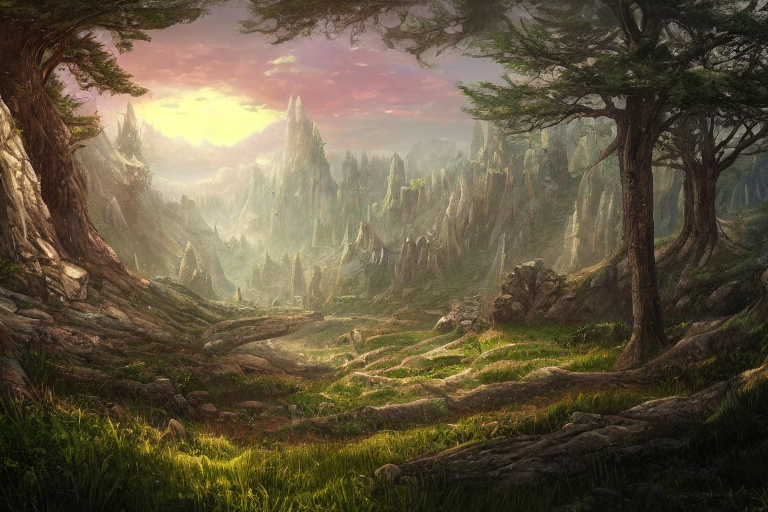

In [ ]:
common_kwargs = {"seed": 2483964025, "width": 768}

prompt = "A fantasy landscape with a pine forest, trending on artstation"
image_origin = stable_diffusion(prompt, **common_kwargs)
image_origin

次に生成した画像に対して `fantasy` 要素を消してみようと思います。`fantasy` は 2 番目のトークンであったため、2 を指定しつつ、その影響度を下げる -8 を重みとして指定します。

In [ ]:
image_edited = stable_diffusion(
    prompt="A fantasy landscape with a pine forest, trending on artstation",
    prompt_edit_token_weights=[(2, -8)],
    **common_kwargs
)
image_grid([image_origin, image_edited], rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.

以上のように、よりリアルな森の画像が生成されました。

次に `winter` という単語をプロンプトに追加することで、生成画像を冬の景色にしてみましょう。

In [ ]:
prompt =      "A fantasy landscape with a pine forest, trending on artstation"
prompt_edit = "A winter fantasy landscape with a pine forest, trending on artstation"

image_edited = stable_diffusion(
    prompt=prompt,
    prompt_edit=prompt_edit,
    **common_kwargs,
)
image_grid([image_origin, image_edited], rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.

指定したとおりに元々の生成画像に対して雪が降ったような画像を生成することができました。

次は水彩画のようなスタイルで生成画像を変更してもらおうと思います。

In [ ]:
prompt      = "A fantasy landscape with a pine forest, trending on artstation"
prompt_edit = "A watercolor painting of a landscape with a pine forest, trending on artstation"

image_edited = stable_diffusion(
    prompt=prompt,
    prompt_edit=prompt_edit,
    **common_kwargs,
)
image_grid([image_origin, image_edited], rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.

オリジナルの画像に対して水彩画のようなスタイルの画像が生成されました。

次は霧 `fog` を生成画像から取り除くように編集してみます。`fog` の位置は `prompt_token` 関数を使って 9 番目であると特定できます。Prompt-to-Prompt 用に用意した `stable_diffusion` 関数の `prompt_edit_token_weight` 引数に `[(fog の位置, そのトークンの重み)]` の形式で、`fog` の影響が小さくなるように -6 を設定してみました。

In [ ]:
prompt =      "A fantasy landscape with a pine forest, trending on artstation"
prompt_edit = "A fantasy landscape with a pine forest with fog, trending on artstation"

target_token = prompt_token(prompt_edit, 9)
print(f"Target token of the edit: {target_token}")

image_edited = stable_diffusion(
    prompt=prompt,
    prompt_edit=prompt_edit,
    prompt_edit_token_weights=[(9, -6)],
    **common_kwargs,
)
image_grid([image_origin, image_edited], rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.

元々の生成画像から霧を取り除いたような画像が生成されました。

次は霧 `fog` に加えて、岩 `rock` も取り除いてみましょう。`prompt_token` 関数で対象のトークンの位置を確認し、`prompt_edit_token_weights` にトークン位置とその重みを設定して画像を生成してみます。

In [18]:
prompt      = "A fantasy landscape with a pine forest, trending on artstation"
prompt_edit = "A fantasy landscape with a pine forest with fog and rocks, trending on artstation"

target_token = prompt_token(prompt_edit, 9)
print(f"Target token of the edit: {target_token}")

target_token = prompt_token(prompt_edit, 11)
print(f"Target token of the edit: {target_token}")

image_edited = stable_diffusion(
    prompt=prompt,
    prompt_edit=prompt_edit,
    prompt_edit_token_weights=[(9, -6), (11, -6)],
    **common_kwargs,
)
image_grid([image_origin, image_edited], rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.

元々の生成画像から霧と岩を取り除いたような画像が生成されました。

最後に生成画像に川を追加してみましょう。`prompt_edit_spatial_end` では大域的な編集をより大きな値を設定することで反映させることが可能です。

In [19]:
prompt      = "A fantasy landscape with a pine forest, trending on artstation"
prompt_edit = "A fantasy landscape with a pine forest and a river, trending on artstation"

image_edited = stable_diffusion(
    prompt=prompt,
    prompt_edit=prompt_edit,
    prompt_edit_spatial_end=0.8,
    **common_kwargs,
)

image_grid([image_origin, image_edited], rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.

以上のようにして Prompt-to-Prompt の動作を確認しました。元々のプロンプトを参考に単語の入れ替えや token, attention の重み付けを変えるなどして柔軟に生成画像を編集することが可能であることを確認しました。